In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import datetime

import PIL
import scipy.io as sio
import numpy as np
import tensorflow as tf
from tensorflow.python.data import AUTOTUNE
from tensorflow.keras import layers
%load_ext tensorboard

### Constants


In [2]:
img_height, img_width = 160, 160
batch_size = 32
root = 'dataset'

### Loading the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


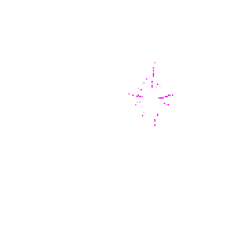

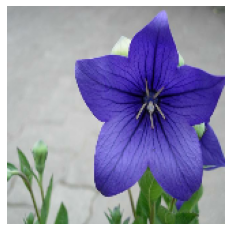

In [22]:
def get_labels_and_images():
    imglabel_map = os.path.join(root, 'imagelabels.mat')
    setid_map = os.path.join(root, 'setid.mat')
    imagelabels = sio.loadmat(imglabel_map)['labels'][0]
    setids = sio.loadmat(setid_map)
    ids = np.concatenate([setids['trnid'][0], setids['valid'][0], setids['tstid'][0]])
    labels, image_path = [] , []
    for i in ids:
        labels.append(int(imagelabels[i - 1]) - 1)
        image_path.append(os.path.join(root, 'jpg', 'image_{:05d}.jpg'.format(i)))
    return image_path, labels

def split_data(ds, suffle=True,val_prop=0.25, test_prop=0.25):
    if suffle:
        ds = ds.shuffle(len(ds), reshuffle_each_iteration=False)

    val_size = int(len(ds) * val_prop)
    test_size = int(len(ds) * test_prop)
    train_ds = list_ds.skip(val_size+test_size)
    val_ds = list_ds.take(val_size)
    test_ds = list_ds.take(test_size)
    return train_ds,val_ds,test_ds

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path, label):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare(ds, shuffle=False):
    resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(img_height, img_width),
        #layers.Rescaling(1. / 255)
    ])
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

image_path, labels = get_labels_and_images()
list_ds = tf.data.Dataset.from_tensor_slices((image_path, labels))
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)

#Splitting the dataset
train_ds,val_ds,test_ds = split_data(list_ds)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

for image, _ in train_ds.take(1):

    # plt.figure(figsize=(10, 10))
    first_image = image[0]
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()
    resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1. / 255)
    ])  
    plt.imshow(resize_and_rescale(first_image))
    plt.axis('off')
    plt.show()

    break
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax2 = plt.subplot(3, 3, i + 2)
        #augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(first_image)
        resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(img_height, img_width),
        layers.Rescaling(1. / 255)
    ])
        plt.axis('off')
        plt.imshow(resize_and_rescale(first_image))
        plt.axis('off')


### Model - Transfer Learning

In [4]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base_model
base_model.trainable = False

In [5]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

#### Creating  the new output layer

In [6]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [7]:
prediction_layer = tf.keras.layers.Dense(len(set(labels)))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 102)


#### Data preprocessing and augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# tf.keras.applications.MobileNetV2 use as the base model.
# This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [23]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

#### Train - First iteration


In [25]:
# Creating callback for the tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

NUM_EPOCHS = 10
history = model.fit(train_ds,
                validation_data=val_ds,
                epochs=NUM_EPOCHS,
                callbacks=tensorboard_callback)

c:\Users\Tomer Hacham\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
128/128 [==============================] - 162s 1s/step - loss: 2.6991 - accuracy: 0.3958 - val_loss: 2.3934 - val_accuracy: 0.5022
Epoch 2/10
128/128 [==============================] - 145s 1s/step - loss: 2.2690 - accuracy: 0.5096 - val_loss: 2.0686 - val_accuracy: 0.5740
Epoch 3/10
128/128 [==============================] - 141s 1s/step - loss: 1.9668 - accuracy: 0.5744 - val_loss: 1.8336 - val_accuracy: 0.6180
Epoch 4/10
128/128 [==============================] - 135s 1s/step - loss: 1.7121 - accuracy: 0.6342 - val_loss: 1.6484 - val_accuracy: 0.6639
Epoch 5/10
128/128 [==============================] - 136s 1s/step - loss: 1.5379 - accuracy: 0.6833 - val_loss: 1.5045 - val_accuracy: 0.6903
Epoch 6/10
128/128 [==============================] - 135s 1s/step - loss: 1.4171 - accuracy: 0.6969 - val_loss: 1.3913 - val_accuracy: 0.7157
Epoch 7/10
128/128 [==============================] - 133s 1s/step - loss: 1.2604 - accuracy: 0.7394 - val_loss: 1.2924 - val_accuracy: 0.7362

### Model - Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#### Recompile and Tune

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  NUM_EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                        validation_data=val_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=tensorboard_callback)